## Import Libraries

In [15]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn import linear_model, ensemble, model_selection, metrics, tree, neighbors
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import decomposition, feature_selection, svm, neighbors, datasets, preprocessing, neighbors, neural_network, dummy
from matplotlib import pyplot

In [16]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from collections import Counter

## Load Data

#### Y matrix (Gene Signature)

In [34]:
Y = pd.read_table('Output/L1000_ClassificationMat_2018_07.tsv')
Y.set_index('pert_id', inplace=True)
Y.head(1)

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Multiple X matricies (Fingerprints)

In [35]:
X1 = pd.read_table('RDKit_fps/Morg1_BMatrix_map_2018_08.tsv')
X1[X1.columns[0]] = X1[X1.columns[0]].astype(str)
X1 = X1.set_index(X1.columns[0])

X2 = pd.read_table('RDKit_fps/TopologicalTorsion_BMatrix_map_2018_08.tsv')
X2[X2.columns[0]] = X2[X2.columns[0]].astype(str)
X2 = X2.set_index(X2.columns[0])

X3 = pd.read_table('RDKit_fps/AtomPair_BMatrix_map_2018_08.tsv')
X3[X3.columns[0]] = X3[X3.columns[0]].astype(str)
X3 = X3.set_index(X3.columns[0])

X4 = pd.read_table('RDKit_fps/MACCs_BMatrix_map_2018_08.tsv')
X4[X4.columns[0]] = X4[X4.columns[0]].astype(str)
X4 = X4.set_index(X4.columns[0])

X5 = pd.read_table('RDKit_fps/RDKfps2_BMatrix_map_2018_08.tsv')
X5[X5.columns[0]] = X5[X5.columns[0]].astype(str)
X5 = X5.set_index(X5.columns[0])

X6 = pd.read_table('RDKit_fps/Avalon_BMatrix_map_2018_08.tsv')
X6[X6.columns[0]] = X6[X6.columns[0]].astype(str)
X6 = X6.set_index(X6.columns[0])

# X7 = pd.read_table('Output/L1000_Scaffolds_2018_07.tsv')
# X7[X7.columns[0]] = X7[X7.columns[0]].astype(str)
# X7 = X7.set_index(X7.columns[0])
# X7 = X7.T


X = pd.concat([X1, X2,X3, X4, X5, X6], axis = 1, sort=True)
# X = pd.concat([X7], axis = 1, sort=True)
X = X.dropna()
X.head()

,Morg1_0,Morg1_1,Morg1_2,Morg1_3,Morg1_4,Morg1_5,Morg1_6,Morg1_7,Morg1_8,Morg1_9,...,Avalon_502,Avalon_503,Avalon_504,Avalon_505,Avalon_506,Avalon_507,Avalon_508,Avalon_509,Avalon_510,Avalon_511
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
BRD-A00267231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
BRD-A00420644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
BRD-A00474148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
BRD-A00520476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [131]:
X.shape

(5435, 10752)

## Eliminate columns from X based on how many zeros it has

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


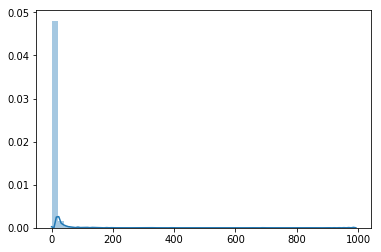

In [19]:
sns.distplot(list(X.sum(axis=0)))

In [21]:
x_col_drop = []
x_amt_nonzero = X.sum(axis=0)
for amt in x_amt_nonzero.iteritems():
    if abs(amt[1]) < 30:
        x_col_drop.append(amt[0])
        
X = X.drop(columns = x_col_drop)
X.shape

(17590, 235)

## Get drugs shared between X and Y

In [22]:
shared_drugs = sorted(list(set(X.index) & set(Y.index)))
X = X.loc[shared_drugs]
Y = Y.loc[shared_drugs]
X = X.values
Y = Y.values

## Normalize Y

In [ ]:
Y = preprocessing.scale(Y)

## Dimentionality Reduction

In [133]:
# dr_model = decomposition.LatentDirichletAllocation(n_components=100, learning_method= 'online')
dr_model = decomposition.NMF(n_components=100, init = 'nndsvda')

X_dr = dr_model.fit_transform(X)

In [135]:
X_dr_df = pd.DataFrame(X_dr)
X_dr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.042308,0.000000,0.007577,0.000000,0.0,0.0,0.031720,0.00000,0.003762,0.0,...,0.0,0.000000,0.131632,0.0,0.000000,0.000000,0.085429,0.000000,0.279394,0.0
1,0.076589,0.051948,0.001481,0.009642,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.036819,0.000000,0.048807,0.000000,0.073638,0.0
2,0.053203,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.046222,0.224360,0.0,0.187921,0.079199,0.000000,0.063804,0.171250,0.0
3,0.000000,0.019689,0.000000,0.153053,0.0,0.0,0.159945,0.01401,0.129881,0.0,...,0.0,0.000000,0.144678,0.0,0.000000,0.025612,0.056816,0.000000,0.000000,0.0
4,0.000000,0.030536,0.070276,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.316596,0.169285,0.0,0.076502,0.000000,0.000000,0.000000,0.105931,0.0


In [136]:
X = X_dr

In [137]:
X.shape, Y.shape

((5188, 100), (5188, 978))

## Pick the classifier

In [23]:
classifier = neighbors.KNeighborsClassifier(n_neighbors = 20, metric = 'jaccard', weights = 'uniform', algorithm = 'auto', leaf_size=30)
# classifier = ensemble.AdaBoostClassifier()
# classifier = ensemble.RandomForestClassifier(n_estimators = 100, n_jobs = 7)
# classifier = neural_network.MLPClassifier()
# classifier = dummy.DummyClassifier(strategy = 'stratified')


## Run the model

In [ ]:
accuracy = []
conf_mats = []
f1s = []
cv = model_selection.KFold(n_splits=4, shuffle=True)
start = time.time()
for train_idx, test_idx in cv.split(X):
    
    X_train, Y_train = X[train_idx], Y[train_idx]
    X_test, Y_test = X[test_idx], Y[test_idx]
    
    classifier.fit(X_train, Y_train)
    Y_test_pred = classifier.predict(X_test)
    
    #measure accuracy of predictor
    accs = [metrics.accuracy_score(Y_test[:,j], Y_test_pred[:, j]) for j in range(Y_test.shape[1])]
    f1 = [metrics.f1_score(Y_test[:,j], Y_test_pred[:, j], average = None) for j in range(Y_test.shape[1])]
    conf_mat = [metrics.confusion_matrix(Y_test[:,j], Y_test_pred[:, j]) for j in range(Y_test.shape[1])]
    accuracy.append(accs)
    conf_mats.append(conf_mat)
    f1s.append(f1)
    
    end = time.time()
    print(end-start)

## Build Confusion Matrix

In [25]:
a,b,c,d,e,f,g,h,i = [],[],[],[],[],[],[],[],[]

for i1 in conf_mats:
    for i2 in i1:
        if len(i2) != 3:
            continue
        a.append(i2[0][0])
        b.append(i2[0][1])
        c.append(i2[0][2])
        d.append(i2[1][0])
        e.append(i2[1][1])
        f.append(i2[1][2])
        g.append(i2[2][0])
        h.append(i2[2][1])
        i.append(i2[2][2])
        
avga = sum(a)/len(a)
avgb = sum(b)/len(b)
avgc = sum(c)/len(c)
avgd = sum(d)/len(d)
avge = sum(e)/len(e)
avgf = sum(f)/len(f)
avgg = sum(g)/len(g)
avgh = sum(h)/len(h)
avgi = sum(i)/len(i)            

In [26]:
a_val = avga / sum([avga, avgb, avgc])
e_val = avge / sum([avgd, avge, avgf])
i_val = avgi / sum([avgg, avgh, avgi])
b_val = avgb / sum([avga, avgb, avgc])
c_val = avgc / sum([avga, avgb, avgc])
d_val = avgd / sum([avgd, avge, avgf])
f_val = avgf / sum([avgd, avge, avgf])
g_val = avgg / sum([avgg, avgh, avgi])
h_val = avgh / sum([avgg, avgh, avgi])

In [ ]:
conf_mat = pd.DataFrame([[a_val,b_val,c_val],[d_val,e_val,f_val],[g_val,h_val,i_val]], columns = [1,0,-1] ,index = [1,0,-1])
conf_mat

In [ ]:
ax = plt.axes()
sns.heatmap(conf_mat, cmap = 'GnBu', annot = True, annot_kws={"size": 15})

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual Value')

plt.savefig('Presentation_figures/classConMat', bbox_inches = 'tight')

### F1 score for the different classes

In [30]:
f1s1= []
f1s0 = []
f1sn1 = []

for i1 in f1s:
    for i2 in i1:
        if len(i2) != 3:
            continue
        f1s1.append(i2[0])
        f1s0.append(i2[1])
        f1sn1.append(i2[2])

In [31]:
f1s1_avg = sum(f1s1)/len(f1s1)
f1s0_avg = sum(f1s0)/len(f1s0)
f1sn1_avg = sum(f1sn1)/len(f1sn1)

f1s1_avg,f1s0_avg,f1sn1_avg

(0.0016678453040611268, 0.9499563130487559, 0.0005014938517289145)

## Plot the Average Accuracy

In [ ]:
data = np.array(accuracy)
aver_data = np.average(data, axis=0)
sns.distplot(aver_data, color = 'green', axlabel = 'Accuracy values' )

In [ ]:
avg = np.average(accuracy)
avg